In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
from datetime import datetime
from IPython.display import clear_output
import pickle

In [2]:
pickle_in = open("cryptocurrency.pickle", "rb") # read in pickle file
df_tweets = pickle.load(pickle_in)
df_tweets.head()

,_id,lang,text,user
5,5cddd6d6fc4f0d82a2c73e46,en,x123456789.eth was just migrated to the new re...,"{'id': 859350218416029696, 'id_str': '85935021..."
8,5cddd6d7fc4f0d82a2c73e49,en,@MYOFFICES @G0JlRA @binance @cz_binance Yeah w...,"{'id': 1067420633615802369, 'id_str': '1067420..."
11,5cddd6d7fc4f0d82a2c73e4c,en,@social77media How about that. I am not knowle...,"{'id': 95009868, 'id_str': '95009868', 'name':..."
12,5cddd6d7fc4f0d82a2c73e4d,en,y123456789.eth was just migrated to the new re...,"{'id': 859350218416029696, 'id_str': '85935021..."
13,5cddd6d7fc4f0d82a2c73e4e,en,Bitcoin [BTC] short worth $84 million closed o...,"{'id': 1020638087242645504, 'id_str': '1020638..."


In [3]:
df_tweets.shape

(32149, 4)

In [4]:
# Make sure tweets are unique and filtered for retweets by removing duplicates 

df_tweets = df_tweets.drop_duplicates(subset=['text'], keep='first')
len(df_tweets)

31730

In [5]:
# Confirm all tweets are in english

df_tweets = df_tweets.drop(df_tweets.index[df_tweets.lang != 'en'])
len(df_tweets)

31730

In [6]:
# Confirm there are no tweets from users with 10 or fewer followers (potential bots)

mask = df_tweets.user.apply(lambda x:x['followers_count'] <= 10)
df_tweets = df_tweets.drop(df_tweets[mask].index)
len(df_tweets)

31730

In [7]:
!pip install tweet-preprocessor

Note: you may need to restart the kernel to use updated packages.


In [8]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from preprocessor.api import clean

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [9]:
## Text preprocessing - remove usernames, url, hashtag, punctuation, alphanumerics, and make all text lowercase

pre_clean = lambda x: clean(x)
remove_username = lambda x: re.sub(r"@\S+", "", x)
drop_url = lambda x: re.sub(r"http\S+", "", x)
remove_hash =  lambda x: x.replace('#','')
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

print(df_tweets.iloc[0].text)
df_tweets['text'] = df_tweets.text.map(pre_clean).map(remove_username).map(drop_url).map(remove_hash).map(alphanumeric).map(punc_lower)
print(df_tweets.iloc[0].text)


x123456789.eth was just migrated to the new registrar https://t.co/HoVHF59Cmx
eth was just migrated to the new registrar


In [10]:
df_tweets.shape

(31730, 4)

In [11]:
def lemma(text):
    lemma = nltk.wordnet.WordNetLemmatizer()
    return lemma.lemmatize(text, pos='v')

In [12]:
tokenizer = TreebankWordTokenizer()

In [13]:
def token_lem(text):
    tokenizer = TreebankWordTokenizer()
    return [lemma(x) for x in tokenizer.tokenize(text)]

In [14]:
token_stem = lambda x: token_stem(x)
df_tweets['text'] = df_tweets.text.apply(token_lem)

,_id,lang,text,user
5,5cddd6d6fc4f0d82a2c73e46,en,"[eth, be, just, migrate, to, the, new, registrar]","{'id': 859350218416029696, 'id_str': '85935021..."
8,5cddd6d7fc4f0d82a2c73e49,en,"[yeah, what, do, you, think, he, instal, in, t...","{'id': 1067420633615802369, 'id_str': '1067420..."
11,5cddd6d7fc4f0d82a2c73e4c,en,"[how, about, that, i, be, not, knowledgeable, ...","{'id': 95009868, 'id_str': '95009868', 'name':..."
12,5cddd6d7fc4f0d82a2c73e4d,en,"[eth, be, just, migrate, to, the, new, registrar]","{'id': 859350218416029696, 'id_str': '85935021..."
13,5cddd6d7fc4f0d82a2c73e4e,en,"[bitcoin, btc, short, worth, million, close, o...","{'id': 1020638087242645504, 'id_str': '1020638..."


In [15]:
print(df_tweets.text[:5])

5     [eth, be, just, migrate, to, the, new, registrar]
8     [yeah, what, do, you, think, he, instal, in, t...
11    [how, about, that, i, be, not, knowledgeable, ...
12    [eth, be, just, migrate, to, the, new, registrar]
13    [bitcoin, btc, short, worth, million, close, o...
Name: text, dtype: object


In [16]:
# Join words back together so they can passed to CountVectorizer

df_tweets['text'] = df_tweets.text.apply(lambda x: ' '.join(x))

In [18]:
print(df_tweets.text[:5])

5              eth be just migrate to the new registrar
8     yeah what do you think he instal in those chur...
11     how about that i be not knowledgeable on bitcoin
12             eth be just migrate to the new registrar
13    bitcoin btc short worth million close on bitfi...
Name: text, dtype: object


In [21]:
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vectorize Tweets and Adding new stop words to the existing english stop words

my_stop_words = text.ENGLISH_STOP_WORDS.union(['bitcoin', 'ethereum', 'crypto', 'btc', 'eth'])

In [25]:
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=my_stop_words, min_df = 5, max_df = .7)
df_countvectorize = vectorizer.fit_transform(df_tweets.text)
type(df_countvectorize)

scipy.sparse.csr.csr_matrix

In [26]:
df_countvectorize.shape

(31730, 12688)

In [27]:
# Try using TF-IDF Vectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words=my_stop_words, min_df = 5, max_df = .7)
df_tfidfvectorize = tfidf_vectorizer.fit_transform(df_tweets.text)
df_tfidfvectorize.shape

(31730, 12688)

In [28]:
# Convert sparse matrix to dataframe to visualize first 5 rows

df_wordcloud = pd.DataFrame(df_countvectorize.toarray(), index=df_tweets['text'], columns=vectorizer.get_feature_names())
df_wordcloud.head()


,aaa,aaa video,aaa video game,ab,abandon,abandon wallet,abandon wallet plan,abandon wallie,abandon wallie custodial,abb,...,zycrypto,𝐌𝐀𝐉𝐎𝐑,𝐌𝐀𝐉𝐎𝐑 𝐌𝐀𝐑𝐊𝐄𝐓,𝐌𝐀𝐉𝐎𝐑 𝐌𝐀𝐑𝐊𝐄𝐓 𝐑𝐀𝐓𝐄𝐒,𝐌𝐀𝐑𝐊𝐄𝐓,𝐌𝐀𝐑𝐊𝐄𝐓 𝐑𝐀𝐓𝐄𝐒,𝐌𝐀𝐑𝐊𝐄𝐓 𝐑𝐀𝐓𝐄𝐒 binance,𝐑𝐀𝐓𝐄𝐒,𝐑𝐀𝐓𝐄𝐒 binance,𝐑𝐀𝐓𝐄𝐒 binance bitfinex
text,,,,,,,,,,,,,,,,,,,,,
eth be just migrate to the new registrar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yeah what do you think he instal in those church sherlock,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
how about that i be not knowledgeable on bitcoin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eth be just migrate to the new registrar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bitcoin btc short worth million close on bitfinex long short ratio stand around read more…,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Topic Modeling with Matrix Factorization

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# Latent Semantic Analysis (LSA) using Singular Value Decomposition (SVD)

lsa = TruncatedSVD(3)
tweet_topics = lsa.fit_transform(df_countvectorize)
lsa.explained_variance_ratio_

array([0.0108685 , 0.01038015, 0.0076784 ])

In [66]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    
    print("Explained Variance: {}%".format(int(lsa.explained_variance_ratio_.sum()*100)))
    
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [67]:
display_topics(lsa, vectorizer.get_feature_names(), 10)

Explained Variance: 2%

Topic  0
blockchain, new, price, platform, use, market, post, launch, rally, just

Topic  1
price, market, usd, current, xrp, new, current price, binance, buy, coin

Topic  2
new, post, just, new post, trade, binance, free, migrate, just migrate, migrate new registrar


In [59]:
# Change df option to display the max width of a column

pd.option_context('display.max_colwidth', -1)

In [75]:
topic_matrix = pd.DataFrame(tweet_topics.round(5), index = df_tweets['text'], columns = ["Blockchain Technology", "Trading/Investing","Free Distribution"])
topic_matrix.sort_values(by = 'Blockchain Technology', ascending = False).head()


,Blockchain Technology,Trading/Investing,Free Distribution
text,,,
blockchain association of africa afriplains digital and blockchain worx to launch blockchain innovation centre ac…,2.76588,-0.74381,-0.65209
cook up your blockchain solution with ibm design think blockchain pulse ibm blockchain blog,2.66851,-0.70812,-0.61933
cook up your blockchain solution with ibm design think blockchain pulse ibm blockchain blog…,2.66851,-0.70812,-0.61933
will g be the catalyst for blockchain and iot adoption blockchain pulse ibm blockchain blog…,2.66207,-0.72167,-0.64566
blockchain job at ibm and how to get one blockchain pulse ibm blockchain blog,2.63652,-0.71468,-0.63683


In [68]:
# Non-Negative Matrix Factorization (NMF)

nmf_model = NMF(3)
nmf_topic = nmf_model.fit_transform(df_countvectorize)
display_topics(nmf_model, vectorizer.get_feature_names(), 10)

Explained Variance: 2%

Topic  0
blockchain, platform, use, launch, rally, technology, wallet, launch blockchain, amro, blockchain technology

Topic  1
price, market, usd, current, current price, xrp, update, analysis, coin, hour

Topic  2
new, post, just, new post, trade, free, binance, buy, migrate, just migrate


In [74]:
topic_matrix = pd.DataFrame(nmf_topic.round(5), index = df_tweets['text'], columns = ["Blockchain Technology", "Trading/Investing","Free Distribution"])
topic_matrix.sort_values(by = 'Blockchain Technology', ascending = False).head()


,Blockchain Technology,Trading/Investing,Free Distribution
text,,,
blockchain association of africa afriplains digital and blockchain worx to launch blockchain innovation centre ac…,0.35016,0.0,0.0
will g be the catalyst for blockchain and iot adoption blockchain pulse ibm blockchain blog…,0.33841,0.0,0.0
cook up your blockchain solution with ibm design think blockchain pulse ibm blockchain blog…,0.33803,0.0,0.0
cook up your blockchain solution with ibm design think blockchain pulse ibm blockchain blog,0.33803,0.0,0.0
blockchain job at ibm and how to get one blockchain pulse ibm blockchain blog,0.33509,0.0,0.0


In [78]:
# LDA (Latent Dirichlet Allocation) Model in Gensim

# Gensim

from gensim import corpora, models, similarities, matutils

# Sklearn

from sklearn import datasets

# Logging for gensim (set to INFO)

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [79]:
# Convert to Gensim

vectorizer.fit(df_tweets.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=5,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=frozenset({'latterly', 'behind', 'hundred', 'one', 'except', 'beside', 'mostly', 'thru', 'himself', 'become', 'both', 'whom', 'formerly', 'sincere', 'neither', 'how', 'during', 'if', 'almost', 'already', 'go', 'wherein', 'eleven', 'thereupon', 'cry', 'about', 'least', 'when', 'everywhere'...ever', 'seeming', 'yet', 'be', 'we', 'have', 'hence', 'within', 'whether', 'what', 'nine', 'empty'}),
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [80]:
lda_doc = vectorizer.transform(df_tweets.text).transpose()

In [81]:
# Convert sparse matrix of counts to a gensim corpus

corpus = matutils.Sparse2Corpus(lda_doc)

In [85]:
# Map matrix rows to words (tokens)

id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
len(id2word)

12688

In [86]:
import warnings
warnings.filterwarnings("ignore")

# Create LDA model (equivalent to "fit" in sklearn)

lda = models.LdaModel(corpus = corpus, num_topics = 3, id2word = id2word, passes = 5)

2019-07-03 01:21:41,626 : INFO : using symmetric alpha at 0.3333333333333333
2019-07-03 01:21:41,627 : INFO : using symmetric eta at 0.3333333333333333
2019-07-03 01:21:41,630 : INFO : using serial LDA version on this node
2019-07-03 01:21:41,641 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 31730 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2019-07-03 01:21:41,649 : INFO : PROGRESS: pass 0, at document #2000/31730
2019-07-03 01:21:42,603 : INFO : merging changes from 2000 documents into a model of 31730 documents
2019-07-03 01:21:42,606 : INFO : topic #0 (0.333): 0.010*"blockchain" + 0.007*"project" + 0.006*"new" + 0.006*"make" + 0.005*"cryptocurrency" + 0.005*"money" + 0.005*"use" + 0.004*"price" + 0.004*"just" + 0.004*"good"
2019-07-03 01:21:42,607 : INFO : topic #1 (0.333): 0.008*"blockchain" + 0.008*"price" + 0.008*"new" + 

2019-07-03 01:21:46,298 : INFO : topic diff=0.364524, rho=0.333333
2019-07-03 01:21:46,836 : INFO : -8.866 per-word bound, 466.7 perplexity estimate based on a held-out corpus of 2000 documents with 16712 words
2019-07-03 01:21:46,837 : INFO : PROGRESS: pass 0, at document #20000/31730
2019-07-03 01:21:47,203 : INFO : merging changes from 2000 documents into a model of 31730 documents
2019-07-03 01:21:47,205 : INFO : topic #0 (0.333): 0.012*"blockchain" + 0.008*"project" + 0.006*"price" + 0.006*"trade" + 0.006*"use" + 0.006*"binance" + 0.005*"make" + 0.005*"cryptocurrency" + 0.005*"usd" + 0.005*"good"
2019-07-03 01:21:47,206 : INFO : topic #1 (0.333): 0.016*"price" + 0.009*"buy" + 0.008*"free" + 0.007*"new" + 0.006*"just" + 0.005*"blockchain" + 0.005*"xrp" + 0.004*"cash" + 0.004*"binance" + 0.004*"sell"
2019-07-03 01:21:47,207 : INFO : topic #2 (0.333): 0.015*"blockchain" + 0.009*"market" + 0.005*"thank" + 0.005*"time" + 0.005*"latest" + 0.004*"price" + 0.004*"daily" + 0.004*"gold" + 0

2019-07-03 01:21:50,540 : INFO : topic diff=0.239408, rho=0.236591
2019-07-03 01:21:50,550 : INFO : PROGRESS: pass 1, at document #6000/31730
2019-07-03 01:21:50,890 : INFO : merging changes from 2000 documents into a model of 31730 documents
2019-07-03 01:21:50,892 : INFO : topic #0 (0.333): 0.014*"blockchain" + 0.008*"project" + 0.008*"trade" + 0.007*"make" + 0.007*"use" + 0.005*"cryptocurrency" + 0.005*"binance" + 0.005*"just" + 0.005*"amp" + 0.005*"good"
2019-07-03 01:21:50,893 : INFO : topic #1 (0.333): 0.017*"price" + 0.011*"new" + 0.010*"buy" + 0.008*"free" + 0.006*"just" + 0.005*"blockchain" + 0.005*"binance" + 0.004*"sell" + 0.004*"post" + 0.004*"xrp"
2019-07-03 01:21:50,894 : INFO : topic #2 (0.333): 0.016*"blockchain" + 0.009*"market" + 0.005*"thank" + 0.004*"long" + 0.004*"article" + 0.004*"latest" + 0.004*"daily" + 0.004*"million" + 0.004*"rally" + 0.003*"new"
2019-07-03 01:21:50,895 : INFO : topic diff=0.221451, rho=0.236591
2019-07-03 01:21:50,905 : INFO : PROGRESS: pass

2019-07-03 01:21:54,307 : INFO : merging changes from 2000 documents into a model of 31730 documents
2019-07-03 01:21:54,309 : INFO : topic #0 (0.333): 0.015*"blockchain" + 0.008*"project" + 0.006*"trade" + 0.006*"use" + 0.005*"make" + 0.005*"platform" + 0.005*"binance" + 0.005*"amp" + 0.004*"just" + 0.004*"wallet"
2019-07-03 01:21:54,310 : INFO : topic #1 (0.333): 0.018*"price" + 0.009*"buy" + 0.009*"free" + 0.008*"new" + 0.006*"just" + 0.005*"binance" + 0.005*"cash" + 0.004*"blockchain" + 0.004*"xrp" + 0.004*"post"
2019-07-03 01:21:54,311 : INFO : topic #2 (0.333): 0.016*"blockchain" + 0.010*"market" + 0.005*"thank" + 0.005*"latest" + 0.004*"cap" + 0.004*"rally" + 0.004*"daily" + 0.004*"market cap" + 0.004*"article" + 0.004*"stock"
2019-07-03 01:21:54,311 : INFO : topic diff=0.223176, rho=0.236591
2019-07-03 01:21:54,320 : INFO : PROGRESS: pass 1, at document #26000/31730
2019-07-03 01:21:54,629 : INFO : merging changes from 2000 documents into a model of 31730 documents
2019-07-03 0

2019-07-03 01:21:58,332 : INFO : topic #1 (0.333): 0.019*"price" + 0.010*"new" + 0.010*"buy" + 0.009*"free" + 0.006*"blockchain" + 0.005*"post" + 0.005*"sell" + 0.005*"xrp" + 0.005*"binance" + 0.004*"just"
2019-07-03 01:21:58,333 : INFO : topic #2 (0.333): 0.015*"blockchain" + 0.008*"market" + 0.005*"daily" + 0.005*"thank" + 0.004*"long" + 0.004*"new" + 0.004*"price" + 0.004*"latest" + 0.004*"rally" + 0.004*"article"
2019-07-03 01:21:58,333 : INFO : topic diff=0.180885, rho=0.230235
2019-07-03 01:21:58,343 : INFO : PROGRESS: pass 2, at document #12000/31730
2019-07-03 01:21:58,635 : INFO : merging changes from 2000 documents into a model of 31730 documents
2019-07-03 01:21:58,638 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.008*"project" + 0.007*"use" + 0.007*"trade" + 0.006*"make" + 0.005*"just" + 0.005*"cryptocurrency" + 0.005*"start" + 0.005*"amp" + 0.005*"platform"
2019-07-03 01:21:58,638 : INFO : topic #1 (0.333): 0.019*"price" + 0.010*"buy" + 0.009*"new" + 0.008*"free" + 0.0

2019-07-03 01:22:01,477 : INFO : topic #2 (0.333): 0.015*"blockchain" + 0.009*"market" + 0.005*"thank" + 0.005*"article" + 0.005*"rally" + 0.004*"cap" + 0.004*"latest" + 0.004*"market cap" + 0.004*"daily" + 0.004*"new"
2019-07-03 01:22:01,478 : INFO : topic diff=0.188554, rho=0.230235
2019-07-03 01:22:01,486 : INFO : PROGRESS: pass 2, at document #30000/31730
2019-07-03 01:22:01,754 : INFO : merging changes from 2000 documents into a model of 31730 documents
2019-07-03 01:22:01,756 : INFO : topic #0 (0.333): 0.015*"blockchain" + 0.008*"project" + 0.007*"use" + 0.007*"trade" + 0.006*"make" + 0.006*"just" + 0.005*"platform" + 0.005*"like" + 0.005*"binance" + 0.005*"amp"
2019-07-03 01:22:01,757 : INFO : topic #1 (0.333): 0.018*"price" + 0.010*"new" + 0.008*"buy" + 0.007*"free" + 0.005*"binance" + 0.005*"trade" + 0.005*"post" + 0.005*"xrp" + 0.004*"craig" + 0.004*"usd"
2019-07-03 01:22:01,758 : INFO : topic #2 (0.333): 0.015*"blockchain" + 0.009*"market" + 0.005*"thank" + 0.004*"article" +

2019-07-03 01:22:04,296 : INFO : topic diff=0.163965, rho=0.224365
2019-07-03 01:22:04,305 : INFO : PROGRESS: pass 3, at document #16000/31730
2019-07-03 01:22:04,557 : INFO : merging changes from 2000 documents into a model of 31730 documents
2019-07-03 01:22:04,560 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.007*"project" + 0.007*"trade" + 0.006*"use" + 0.006*"make" + 0.006*"just" + 0.005*"like" + 0.005*"start" + 0.005*"binance" + 0.005*"amp"
2019-07-03 01:22:04,561 : INFO : topic #1 (0.333): 0.020*"price" + 0.010*"buy" + 0.009*"new" + 0.008*"free" + 0.006*"post" + 0.005*"sell" + 0.005*"xrp" + 0.005*"usd" + 0.005*"cash" + 0.005*"binance"
2019-07-03 01:22:04,562 : INFO : topic #2 (0.333): 0.012*"blockchain" + 0.008*"market" + 0.005*"rally" + 0.004*"daily" + 0.004*"article" + 0.004*"price" + 0.004*"thank" + 0.004*"new" + 0.004*"latest" + 0.004*"time"
2019-07-03 01:22:04,563 : INFO : topic diff=0.154151, rho=0.224365
2019-07-03 01:22:04,572 : INFO : PROGRESS: pass 3, at document #

2019-07-03 01:22:07,542 : INFO : PROGRESS: pass 4, at document #2000/31730
2019-07-03 01:22:07,793 : INFO : merging changes from 2000 documents into a model of 31730 documents
2019-07-03 01:22:07,795 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.008*"project" + 0.007*"use" + 0.007*"make" + 0.007*"just" + 0.006*"trade" + 0.006*"like" + 0.005*"amp" + 0.005*"binance" + 0.004*"platform"
2019-07-03 01:22:07,796 : INFO : topic #1 (0.333): 0.018*"price" + 0.011*"new" + 0.008*"free" + 0.008*"buy" + 0.005*"xrp" + 0.005*"binance" + 0.005*"post" + 0.004*"trade" + 0.004*"just" + 0.004*"usd"
2019-07-03 01:22:07,797 : INFO : topic #2 (0.333): 0.015*"blockchain" + 0.009*"market" + 0.005*"thank" + 0.005*"article" + 0.004*"firm" + 0.004*"rally" + 0.004*"million" + 0.004*"daily" + 0.004*"latest" + 0.003*"new"
2019-07-03 01:22:07,798 : INFO : topic diff=0.178047, rho=0.218923
2019-07-03 01:22:07,806 : INFO : PROGRESS: pass 4, at document #4000/31730
2019-07-03 01:22:08,067 : INFO : merging changes fr

2019-07-03 01:22:10,611 : INFO : topic #1 (0.333): 0.021*"price" + 0.009*"buy" + 0.009*"free" + 0.008*"new" + 0.006*"xrp" + 0.005*"binance" + 0.005*"hour" + 0.005*"cash" + 0.005*"usd" + 0.005*"post"
2019-07-03 01:22:10,612 : INFO : topic #2 (0.333): 0.012*"blockchain" + 0.008*"market" + 0.005*"daily" + 0.005*"thank" + 0.005*"latest" + 0.005*"rally" + 0.004*"new" + 0.004*"article" + 0.004*"price" + 0.004*"time"
2019-07-03 01:22:10,612 : INFO : topic diff=0.139652, rho=0.218923
2019-07-03 01:22:10,622 : INFO : PROGRESS: pass 4, at document #22000/31730
2019-07-03 01:22:10,878 : INFO : merging changes from 2000 documents into a model of 31730 documents
2019-07-03 01:22:10,881 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.007*"project" + 0.006*"use" + 0.006*"make" + 0.005*"just" + 0.005*"platform" + 0.005*"like" + 0.005*"trade" + 0.005*"amp" + 0.005*"binance"
2019-07-03 01:22:10,881 : INFO : topic #1 (0.333): 0.021*"price" + 0.010*"free" + 0.009*"buy" + 0.008*"new" + 0.006*"xrp" + 0.00

In [87]:
lda.print_topics(num_words = 10)

2019-07-03 01:24:23,168 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.007*"project" + 0.007*"use" + 0.007*"make" + 0.006*"just" + 0.006*"trade" + 0.005*"like" + 0.005*"amp" + 0.005*"platform" + 0.005*"new"
2019-07-03 01:24:23,170 : INFO : topic #1 (0.333): 0.019*"price" + 0.010*"new" + 0.008*"buy" + 0.008*"free" + 0.006*"xrp" + 0.005*"binance" + 0.005*"trade" + 0.005*"post" + 0.004*"usd" + 0.004*"craig"
2019-07-03 01:24:23,171 : INFO : topic #2 (0.333): 0.014*"blockchain" + 0.009*"market" + 0.005*"thank" + 0.005*"article" + 0.004*"firm" + 0.004*"daily" + 0.004*"million" + 0.004*"new" + 0.004*"latest" + 0.004*"cap"


[(0,
  '0.016*"blockchain" + 0.007*"project" + 0.007*"use" + 0.007*"make" + 0.006*"just" + 0.006*"trade" + 0.005*"like" + 0.005*"amp" + 0.005*"platform" + 0.005*"new"'),
 (1,
  '0.019*"price" + 0.010*"new" + 0.008*"buy" + 0.008*"free" + 0.006*"xrp" + 0.005*"binance" + 0.005*"trade" + 0.005*"post" + 0.004*"usd" + 0.004*"craig"'),
 (2,
  '0.014*"blockchain" + 0.009*"market" + 0.005*"thank" + 0.005*"article" + 0.004*"firm" + 0.004*"daily" + 0.004*"million" + 0.004*"new" + 0.004*"latest" + 0.004*"cap"')]

In [88]:
# Clustering Using tSNE for Visualization

from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

topic_matrix.head()

,Blockchain Technology,Trading/Investing,Free Distribution
text,,,
eth be just migrate to the new registrar,0.31046,0.20282,1.44936
yeah what do you think he instal in those church sherlock,0.01962,0.01134,0.02343
how about that i be not knowledgeable on bitcoin,0.00005,0.00017,0.00016
eth be just migrate to the new registrar,0.31046,0.20282,1.44936
bitcoin btc short worth million close on bitfinex long short ratio stand around read more…,0.10747,0.05015,0.09966


In [90]:
# Assign topic id for each tweet

topic_matrix.loc[topic_matrix['Blockchain Technology'] == topic_matrix.max(axis=1), 'topic_id'] =  0
topic_matrix.loc[topic_matrix['Trading/Investing'] == topic_matrix.max(axis=1), 'topic_id'] =  1
topic_matrix.loc[topic_matrix['Free Distribution'] == topic_matrix.max(axis=1), 'topic_id'] =  2
topic_matrix.head()

,Blockchain Technology,Trading/Investing,Free Distribution,topic_id
text,,,,
eth be just migrate to the new registrar,0.31046,0.20282,1.44936,2.0
yeah what do you think he instal in those church sherlock,0.01962,0.01134,0.02343,2.0
how about that i be not knowledgeable on bitcoin,0.00005,0.00017,0.00016,1.0
eth be just migrate to the new registrar,0.31046,0.20282,1.44936,2.0
bitcoin btc short worth million close on bitfinex long short ratio stand around read more…,0.10747,0.05015,0.09966,0.0


In [94]:
topic_matrix.groupby('topic_id')['Blockchain Technology'].count()

topic_id
0.0    11174
1.0     8834
2.0    11722
Name: Blockchain Technology, dtype: int64

In [95]:
target = topic_matrix['topic_id']
target_names = topic_matrix.columns[0:4]
colors = ['r','g','b']
target_ids = range(len(target_names))
X = nmf_topic

In [96]:
model = TSNE(n_components=2, random_state=0,verbose=0)
tsne_data = model.fit_transform(X)

/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


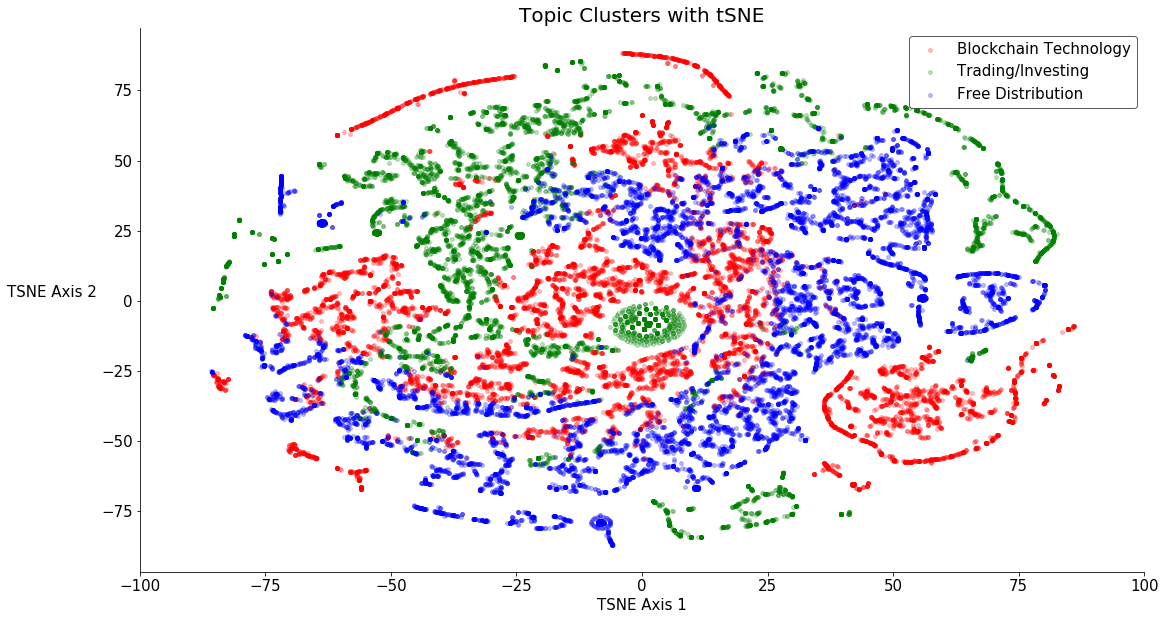

In [97]:
colorize = []

fig, ax = plt.subplots(figsize=(18, 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i, c, label in zip(target_ids, colors, target_names):
        ax = plt.scatter(tsne_data[target == i, 0], tsne_data[target == i, 1], c=c, label=label, s=15, alpha=.25)


plt.legend(fontsize=15, loc='bottom right', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
plt.xlim(-100,100);
plt.title("Topic Clusters with tSNE", fontsize=20)
plt.ylabel("TSNE Axis 2", fontsize=15, rotation='horizontal', ha='right')
plt.xlabel("TSNE Axis 1", fontsize=15);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

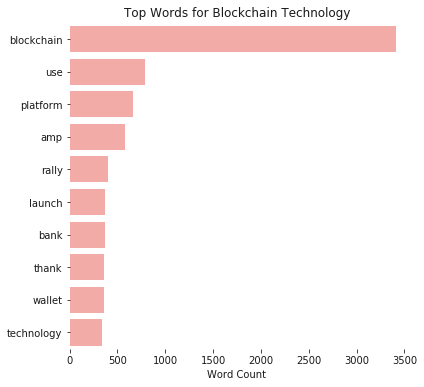

In [107]:
# Word Count Visualization

import seaborn as sns

result = df_wordcloud.copy()
result['topic'] = topic_matrix['topic_id']
topic_1 = pd.DataFrame(result[result['topic']==0].sum(axis=0).sort_values(ascending=False).head(10))
topic_1.columns=['count']

plt.subplots(figsize=(6, 6))
sns.set_color_codes("pastel")
plot_1 = sns.barplot(x='count', y=topic_1.index, data=topic_1, color="r")
plot_1.set(xlim=(0, 3500), ylabel="", xlabel="Word Count")
sns.despine(left=True, bottom=True)
plt.title('Top Words for Blockchain Technology');

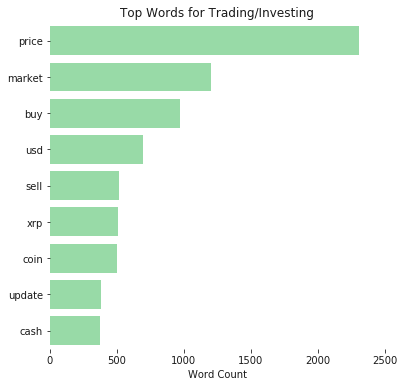

In [111]:
topic_2 = pd.DataFrame(result[result['topic']==1].sum(axis=0).sort_values(ascending=False).head(10))
topic_2.columns=['count']
topic_2 = topic_2.drop('topic')

plt.subplots(figsize=(6, 6))
sns.set_color_codes("pastel")
plot_2 = sns.barplot(x='count', y=topic_2.index, data=topic_2, color="g")
plot_2.set(xlim=(0, 2500), ylabel="", xlabel="Word Count")
sns.despine(left=True, bottom=True)
plt.title('Top Words for Trading/Investing');

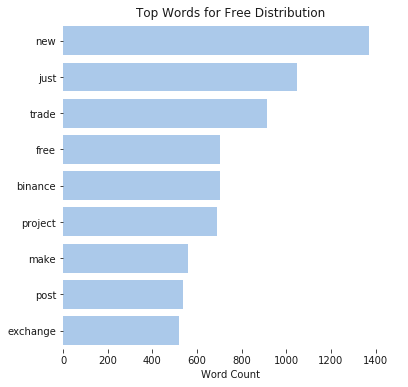

In [113]:
topic_3 = pd.DataFrame(result[result['topic']==2].sum(axis=0).sort_values(ascending=False).head(10))
topic_3.columns=['count']
topic_3 = topic_3.drop('topic')

plt.subplots(figsize=(6, 6))
sns.set_color_codes("pastel")
plot_3 = sns.barplot(x='count', y=topic_3.index, data=topic_3, color="b")
plot_3.set(xlim=(0, 1500), ylabel="", xlabel="Word Count")
sns.despine(left=True, bottom=True)
plt.title('Top Words for Free Distribution');

In [114]:
# Using PCA for Visualization

from sklearn.decomposition import PCA

X = df_countvectorize

# Take all of the data and plot it on 2 dimensions

pca = TruncatedSVD(n_components=2)
pca.fit(X)
pca_data = pca.transform(X)

In [115]:
# Create a plot of the PCA results

from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend(fontsize=12, loc='upper right', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')

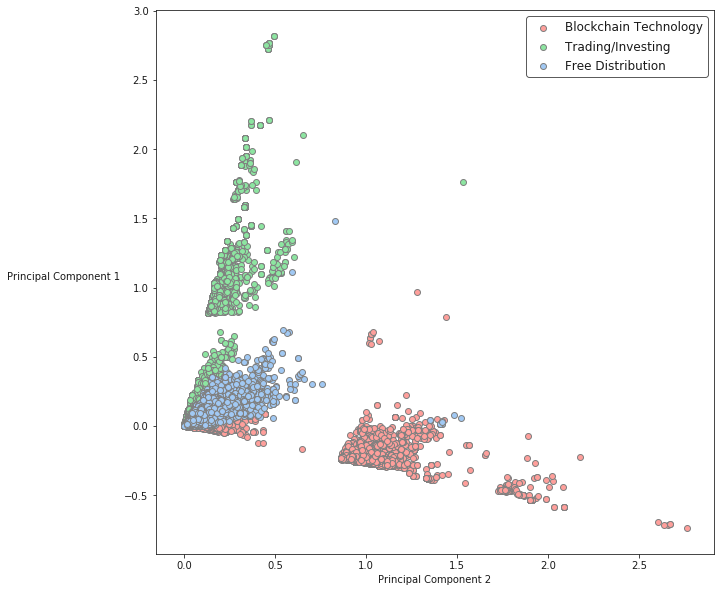

In [116]:
# plot of all topics

plot_PCA_2D(pca_data, target=target, target_names=topic_matrix.columns[0:3])
plt.ylabel("Principal Component 1",fontsize=10, rotation='horizontal', ha='right')
plt.xlabel('Principal Component 2',fontsize=10);

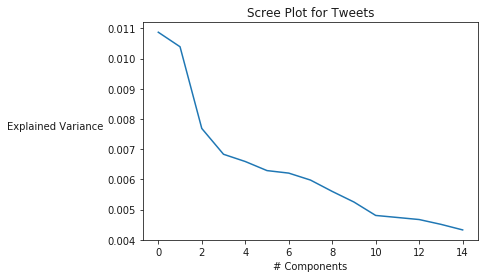

In [117]:
# Looking at the number of topics using scree plot

pca2 = TruncatedSVD(n_components=15)
pca2.fit(X)
pca_data2 = pca2.transform(X)

plt.plot(pca2.explained_variance_ratio_)
plt.xlabel('# Components')
plt.ylabel('Explained Variance', rotation='horizontal', ha='right');
plt.title('Scree Plot for Tweets');

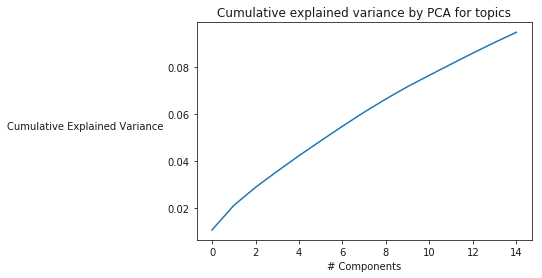

In [119]:
# Look at cumulative explained variance

plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('# Components')
plt.ylabel('Cumulative Explained Variance', rotation='horizontal', ha='right');
plt.title('Cumulative explained variance by PCA for topics');

In [120]:
# Heirarchical Agglomerative Clustering

X = pca_data

ward : 51.43s
average : 39.05s
complete : 33.57s


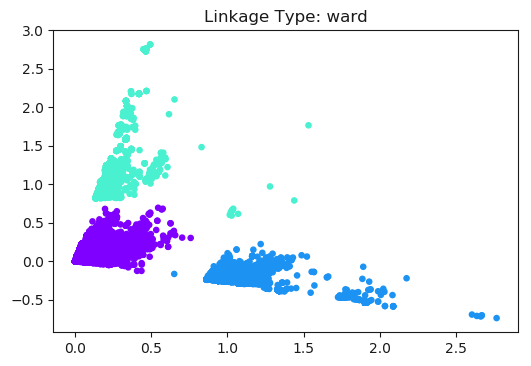

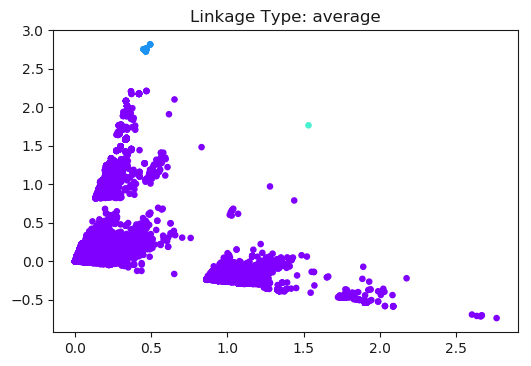

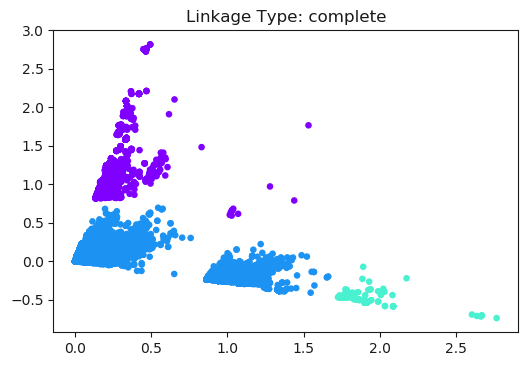

In [121]:
from time import time
from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=3)
    t0 = time()
    clustering.fit(X)
    print("%s : %.2fs" % (linkage, time() - t0))
    
    x,y = zip(*X)
    plt.figure(dpi=100)
    plt.scatter(x,y,c=plt.cm.rainbow(clustering.labels_*50),s=14)
    plt.title("Linkage Type: %s" % linkage)

In [122]:
# K-MEANS Clustering

from sklearn.cluster import KMeans

# Helper function that allows us to display data in 2 dimensions and highlights the clusters

def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    plt.figure(dpi=100)
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)


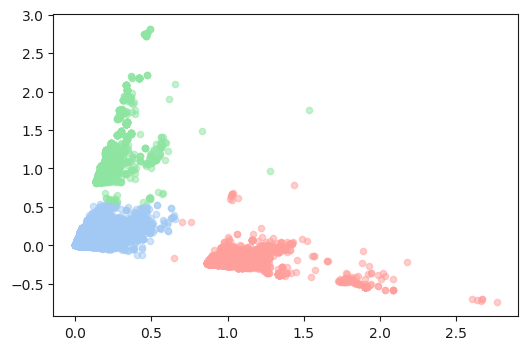

In [123]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters,random_state=20,n_init=1)
km.fit(X)
display_cluster(X,km,num_clusters)

In [124]:
# MeanShift Clustering

from sklearn.cluster import MeanShift, estimate_bandwidth

# Estimate bandwidth 

bandwidth = estimate_bandwidth(X, quantile=.2, n_samples=1000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 13


<Figure size 432x288 with 0 Axes>

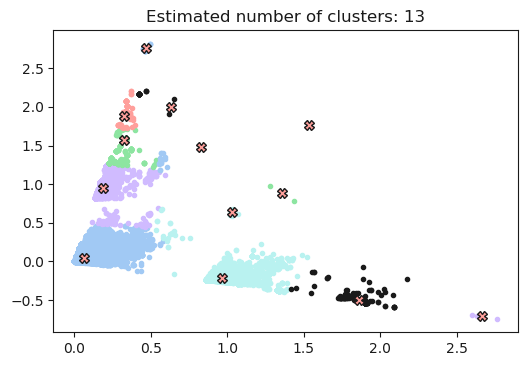

In [126]:
from itertools import cycle

plt.figure(1);
plt.clf();
plt.figure(dpi=100);
colors = cycle('bcmgkr')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1] ,  col + '.');
    plt.plot(cluster_center[0], cluster_center[1], 'X', markerfacecolor='r', markeredgecolor='k', markersize=7);
plt.title('Estimated number of clusters: %d' % n_clusters_);

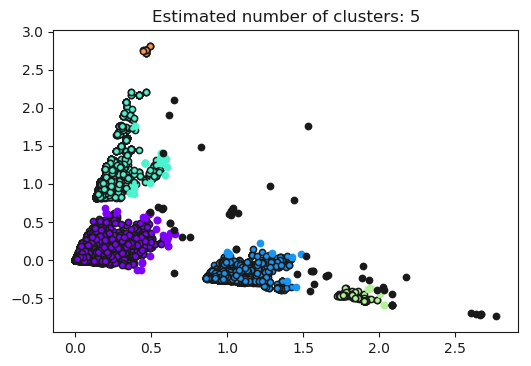

In [127]:
# DBSCAN Clustering

from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.preprocessing import StandardScaler

# Standardize the data for DBSCAN and fit DBSCAN

db = DBSCAN(eps=.1, min_samples=20).fit(X)

# Let's find the observations DBSCAN called "core"

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(dpi=100)
show_core = True
show_non_core = True
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'  # Black used for noise

    class_member_mask = (labels == k)
    if show_core:
        xy = X[class_member_mask & core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # Add black border for core points
    
    if show_non_core:
        xy = X[class_member_mask & ~core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, s=20, linewidths=1.1)

plt.title('Estimated number of clusters: %d' % n_clusters_);

In [128]:
# Sentiment Analysis

corpus = df_tweets['text']
corpus.head()

5              eth be just migrate to the new registrar
8     yeah what do you think he instal in those chur...
11     how about that i be not knowledgeable on bitcoin
12             eth be just migrate to the new registrar
13    bitcoin btc short worth million close on bitfi...
Name: text, dtype: object

In [129]:
!pip install afinn

  Using cached https://files.pythonhosted.org/packages/86/e5/ffbb7ee3cca21ac6d310ac01944fb163c20030b45bda25421d725d8a859a/afinn-0.1.tar.gz
  Stored in directory: /Users/jacob/Library/Caches/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [130]:
# Initialize afinn sentiment analyzer

from afinn import Afinn
af = Afinn(emoticons=True)

# Compute sentiment scores (polarity) and labels

sentiment_scores = [af.score(i) for i in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    

topic_matrix['topic_name'] = topic_matrix.topic_id.replace({0: 'Blockchain Technology', 1: 'Trading/Investing', 2:\
                                                            'Free Distribution'})

# Sentiment statistics per news category

df_sentiment = pd.DataFrame([list(topic_matrix.topic_name), sentiment_scores, sentiment_category]).T
df_sentiment.columns = ['Topic', 'sentiment_score', 'sentiment_category']
df_sentiment['sentiment_score'] = df_sentiment.sentiment_score.astype('float')
df_sentiment.groupby(by=['Topic']).describe()

sentiment_score                                      \
                                count      mean       std   min  25%  50%   
Topic                                                                       
Blockchain Technology         11174.0  0.636478  1.959433 -12.0  0.0  0.0   
Free Distribution             11722.0  0.920577  2.323306 -12.0  0.0  0.0   
Trading/Investing              8834.0  0.292619  1.524641 -11.0  0.0  0.0   

                                   
                        75%   max  
Topic                              
Blockchain Technology  2.00  15.0  
Free Distribution      2.00  16.0  
Trading/Investing      0.75  10.0

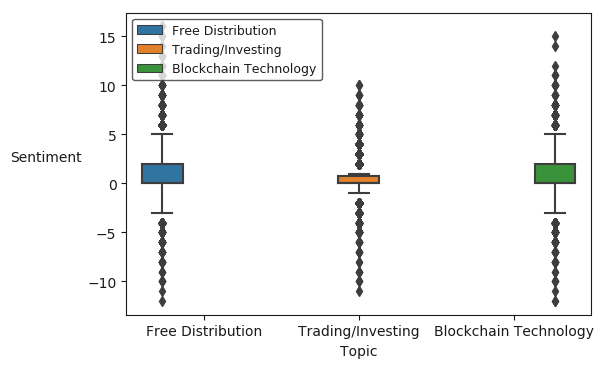

In [133]:
plt.figure(dpi=100)
sns.boxplot(x='Topic', y="sentiment_score", 
                 hue='Topic', data=df_sentiment)
plt.legend(fontsize=9, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
plt.ylabel("Sentiment", rotation='horizontal', ha='right');

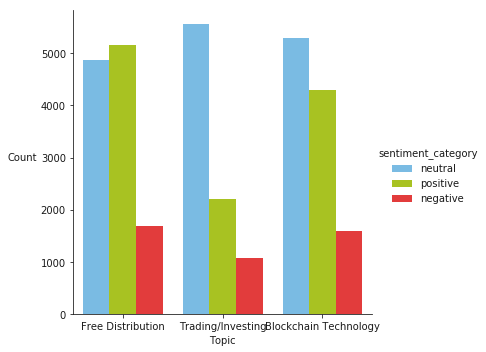

In [145]:
sns.catplot(x="Topic", hue="sentiment_category", 
                    data=df_sentiment, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})
plt.ylabel("Count", rotation='horizontal', ha='right');